# ising model

we've got a set $\Lambda$ of nodes, each with adjacent nodes forming a d-dimensional lattice. for each node $k \in \Lambda$, there is a discrete $\sigma_k \in \{ -1, +1 \}$.

a spin configuration, $\sigma = \{ \sigma_k \}_{k \in \Lambda}$

$$
H(\sigma) = - \sum_{<ij>} J_{ij}\sigma_i \sigma_j - \mu \sum_j h_j \sigma_j
$$

where the first sum is over pairs of adjacent spins (each pair counted once), and the notation $<ij>$ means nodes $i$ and $j$ are nearest neighbors. the magnetic moment is given by $\mu$. 

for this simple model i wont include the external magnetic field $h_j$ and i will use a universal coupling constant $J$. so the hamiltonian will be:
$$
H(\sigma) = - J \sum_{<ij>} \sigma_i \sigma_j
$$

the configuration probability is given by the Boltzmann distribution
$$
P_{\beta}(\sigma) = \frac{1}{Z_{\beta}} \exp \left\{ -\beta H(\sigma) \right\}
$$

with *inverse* temperature
$$
\beta = \frac{1}{k_b T}
$$

note that we have the normalization constant 
$$
Z_\beta = \sum_{\sigma} \exp \left\{ -\beta H(\sigma) \right\}
$$
which serves as the partition function. 

metropolis-hastings chooses selection probabilities $g(\mu, \nu)$ representing the probability that state $\nu$ is selected by the algorithm out of all states, given that one is in state $\mu$ i.e. $P(\nu | \mu)$. then it uses acceptance probabilities $A(\mu, \nu)$ to satisfy *detailed balance*. 

if $\nu$ is accepted $\rightarrow$ move to that state and repeat with new candidate

else $\rightarrow$ stay in $\mu$, with updated acceptance probability

when implementing, you need to ensure that $g(\mu, \nu)$ satisfies ergodicity. in thermal equilibrium a system's energy only fluctuates within a small range. this is the motivation behind *single-spin-flip dynamics* i.e. in each transition we only change one spin site on the lattice. 

NOTE: metropolis-hastings does not perform well at the critical point, look into multigrid, niedermayer, swendsen-wang, or wolff algorithm.

since there are $L$ total sites on the lattice, with single-flip dynamics, there are a total of $L$ new states $\nu$ from current state $\mu$. the algorithm assumes that selection probabilities are equal to the L states
$$
g(\mu, \nu) = \frac{1}{L}
$$

*detailed balance* tells us the following must hold:
$$
\frac{P(\mu, \nu)}{P(\nu, \mu)} = 
\frac{g(\mu, \nu)A(\mu, \nu)}{g(\nu, \mu)A(\nu, \mu)} =
\frac{A(\mu, \nu)}{A(\nu, \mu)} =
\frac{P_\beta(\nu)}{P_\beta(\mu)} =
\frac{\frac{1}{Z_\beta} e^{-\beta H_\nu}}{\frac{1}{Z_\beta} e^{-\beta H_\mu}} =
e^{-\beta (H_\nu - H_\mu)}
$$

thus we want to select acceptance probabilit that satisfies
$$
\frac{A(\mu, \nu)}{A(\nu, \mu)} = e^{-\beta (H_\nu - H_\mu)}
$$

if $H_\nu > H_\mu$, then $A(\nu, \mu) > A(\mu, \nu)$ (i.e. if $\Delta H > 0$)
M-H sets the larger of the acceptance probabilities to be 1. by this reasoning, the acceptance algorithm is:
$$
A(\mu, \nu) = 
\begin{cases}
e^{-\beta ( H_\nu - H_\mu )} & \text{if } H_\nu - H_\mu > 0 \\
1                          & \text{otherwise.} \\
\end{cases}
$$

the basic form of the algorithm is:
1. pick a spin site using selection probability $g(\mu, \nu)$ and calculate the contribution to the energy involving this spin

2. flip the value of the spin and calculate the new contribution

3. if the new energy is less, keep the flipped value

4. if the new energy is more, only keep with probability $e^{\beta (H_\nu - H_\mu)}$

5. repeat

the change in energy only depends on the value of the spin and its nearest neighbors, so if the graph is not too connected, the algorithm is fast. this process will eventually produce a pick from the distribution.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

rng = np.random.default_rng()

In [50]:
# PARAMS
L = 8  # 3x3 grid for now
beta = 1 / 300  # 300K tempereature
J = 1  # no coupling constant rn

In [51]:
# generate initial config
initial = rng.choice([-1, 1], size=(L,L))
print(initial)

[[ 1  1  1  1  1  1  1 -1]
 [-1 -1  1  1  1 -1  1 -1]
 [-1 -1 -1  1  1  1 -1 -1]
 [-1 -1  1  1  1 -1 -1  1]
 [ 1 -1  1  1 -1 -1  1  1]
 [-1 -1 -1  1  1  1 -1  1]
 [-1  1  1  1 -1 -1  1 -1]
 [-1 -1 -1  1 -1  1 -1  1]]


In [52]:
# calculate the energy of an entire config
def H(c):
    # kernel for 4 neighbors
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    # sum of neighbors for each spin
    neighbor_sum = convolve2d(c, kernel, mode='same', boundary='fill', fillvalue=0)

    # spin-spin interactions on each, divide by 2 to avoid double count
    total_energy = np.sum(initial * neighbor_sum) / 2

    return total_energy

In [ ]:
# calculate energy delta between two configs (NO PERIODIC BOUNDARY)
def local_H(c, i, j):
    # pad with zeros to avoid index errors
    padded = np.pad(c, pad_width=1, mode='constant', constant_values=0)

    # be mindful that our indices are -1 for the paddded config
    neighbors = [
        padded[i, j+1],   # up
        padded[i+2, j+1], # down
        padded[i+1, j],   # left
        padded[i+1, j+2]  # right
    ]

    return -c[i,j] * sum(neighbors)

In [54]:
# metropolis-hastings D:

def metropolis_step(c):
    i = rng.integers(0,L)
    j = rng.integers(0,L)

    delta_H = local_H(c, i, j)

    acceptance = np.exp(-beta * delta_H)

    if acceptance > rng.random():
        c[i,j] *= -1
    return c


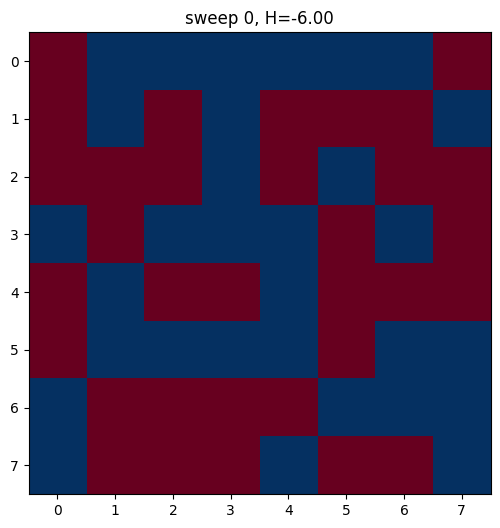

In [57]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

c = initial.copy()
fig, ax = plt.subplots(figsize=(6,6))

for sweep in range(0, 100):
    # each sweep, attempt a swap for each spin
    for step in range(0, L*L):
        c = metropolis_step(c)
    # then measure results
    clear_output(wait=True)
    ax.clear()
    ax.imshow(c, cmap='RdBu', vmin=-1, vmax=1)
    ax.set_title(f'sweep {sweep}, H={H(c):.2f}')
    plt.show()

In [ ]:
def initial(N):
    state = 2 * np.random.randint(2, size=(N,N)) - 1
    return state 

def energy(config, N):
    energy = 0
    for i in range(N):
        for j in range(N):
            S = config[i,j]
            nb = (config[(i+1)%self.N, j] + config[i,(j+1)%self.N] + 
                    config[(i-1)%self.N, j] + config[i,(j-1)%self.N])
            energy += -S * nb
    return energy / 2 # avoid double counting

def local_energy_delta(config, i, j, N):
    s = config[i, j]
    nb = (config[(i+1)%self.N, j] + config[i,(j+1)%self.N] + 
            config[(i-1)%self.N, j] + config[i,(j-1)%self.N])
    return 2 * s * nb

def metropolis_step(config, N, beta):
    i = np.random.randint(0, N)
    j = np.random.randint(0, N)

    delta_E = local_energy_delta(config, i, j, N)
    

